In [1]:
import pandas as pd 
import numpy as np
from matplotlib import style
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#tdqm = progress bar
from tqdm import tqdm
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn. model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

In [2]:
# Number of rows
nrows = 10000
# Chunksize = 10000 
chunksize = 10000
# Vitou's path
# path = 'C:/Users/sirus/Downloads/train.csv'
# Muna's path
path = '/Users/muna/Development/DataScience/new-york-city-taxi-fare-prediction/train.csv'
# Columns to read from the data
# Todo :split date into meaningful data
# cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']
cols = ['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','fare_amount']

#list to hold the batch dataframe
df_list = []

for df_chunk in tqdm(pd.read_csv(path,usecols=cols, chunksize=chunksize,nrows=nrows)):
    df_list.append(df_chunk)
    
# Merge all dataframes into one dataframe
data = pd.DataFrame()
data = pd.concat(df_list)
# # Delete the dataframe list to release memory
del df_list, df_chunk

1it [00:00, 39.64it/s]


### Let's take a look at the data

In [3]:
%%time
# data.describe(include='all')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


### Check for missing values

In [4]:
%%time
# Checking for missing values
data.isnull().sum()

CPU times: user 2.91 ms, sys: 1.37 ms, total: 4.28 ms
Wall time: 3.11 ms


fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### From our observation, there are some missing values, so we remove them

In [5]:
%%time
data = data.dropna(how = 'any', axis = 'rows')

CPU times: user 5.23 ms, sys: 1.89 ms, total: 7.12 ms
Wall time: 5.94 ms


### Let's take a look at the data

In [6]:
data['fare_amount'].describe()

count    10000.000000
mean        11.235464
std          9.584258
min         -2.900000
25%          6.000000
50%          8.500000
75%         12.500000
max        180.000000
Name: fare_amount, dtype: float64

### From the description above, some of the fare_amount have negative values

We are going to remove all negatvie fare_amounts

In [7]:
%%time
data = data[(data['fare_amount'] > 0)]

CPU times: user 2.53 ms, sys: 1.19 ms, total: 3.72 ms
Wall time: 2.81 ms


In [8]:
data['fare_amount'].describe()

count    9998.000000
mean       11.238252
std         9.583189
min         0.010000
25%         6.000000
50%         8.500000
75%        12.500000
max       180.000000
Name: fare_amount, dtype: float64

In [9]:
data['fare_amount'].describe()

count    9998.000000
mean       11.238252
std         9.583189
min         0.010000
25%         6.000000
50%         8.500000
75%        12.500000
max       180.000000
Name: fare_amount, dtype: float64

### Let's take a detailed look at the passenger count

In [10]:
data['passenger_count'].describe()

count    9998.000000
mean        1.644829
std         1.271324
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

The highest passenger count per taxi ride is 208, which is not possible. So we remove all passenger_count grater than 6, since 6 is the maximum passenger capacity for Uber/Lyft if the ride is an SUV

In [11]:
data = data[(data['passenger_count'] <= 6)]

In [12]:
data['passenger_count'].describe()

count    9998.000000
mean        1.644829
std         1.271324
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

Now the highest passenger capacity is 6

Next we remove all passenger count that are zero

In [13]:
data = data[(data['passenger_count'] > 0)]

In [14]:
data['passenger_count'].describe()

count    9960.000000
mean        1.651104
std         1.269673
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

### Looking at the pickup|droppoff latitudes and longitudes

In [15]:
data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,9960.000000,9960.000000,9960.000000,9960.000000
mean,39.917140,-72.460645,39.889853,-72.468110
std,7.333429,10.630589,6.352406,10.600535
min,-74.006893,-74.438233,-73.994392,-74.429332
25%,40.734558,-73.992065,40.735230,-73.991095
50%,40.752695,-73.981758,40.753732,-73.980083
75%,40.767700,-73.966925,40.768180,-73.963504
max,401.083332,40.766125,41.366138,40.802437


Looking at the info above, the maximum pickup_latitude/pickup_longtide/droppoff_latitude/dropoff_longitude are over 3000 WITH their respective minimum values are over -3000

Latitudes range from -90 to 90 while longitudes range from -180 to 180, for single degree format. So we remove all values that are not with the latitude and longitude ranges

In [16]:
data = data.drop((data[(data['pickup_latitude'] > 90) | (data['pickup_latitude'] < -90)]).index, axis=0)

In [17]:
data = data.drop((data[(data['pickup_longitude'] > 180) | (data['pickup_longitude'] < -180)]).index, axis=0)

We will do the same for dropoff cordinates

In [18]:
data = data.drop((data[(data['dropoff_latitude'] > 90) | (data['dropoff_latitude'] < -90)]).index, axis=0)

In [19]:
data = data.drop((data[(data['dropoff_longitude'] > 180) | (data['dropoff_longitude'] < -180)]).index, axis=0)

In [20]:
data[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,9959.000000,9959.000000,9959.000000,9959.000000
mean,39.880875,-72.460495,39.889764,-72.467961
std,6.378412,10.631112,6.352719,10.601057
min,-74.006893,-74.438233,-73.994392,-74.429332
25%,40.734555,-73.992066,40.735227,-73.991097
50%,40.752694,-73.981762,40.753730,-73.980087
75%,40.767695,-73.966942,40.768180,-73.963517
max,41.366138,40.766125,41.366138,40.802437


### Feature Engineering

In [21]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(data)

### In further observation, we have pickup_longitude, puckup_latitiude, dropoff_longitude and dropoff_latitude. We can calculate the distance

In [22]:
# Function that calculates distance between pickup location and dropoff location
def getDistance(lat1,lon1,lat2,lon2):
    r = 6378 # earth's radius
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = r*c
    
    return distance



In [23]:
%%time
# Add new cloumn "distance" to the data
data['distance'] = getDistance(data.pickup_latitude, data.pickup_longitude, 
                                      data.dropoff_latitude, data.dropoff_longitude)

CPU times: user 10.1 ms, sys: 1.9 ms, total: 12 ms
Wall time: 12.5 ms


In [24]:
data['distance'].describe()

count    9959.000000
mean       12.765564
std       276.576377
min         0.000000
25%         1.207190
50%         2.122509
75%         3.881621
max      8677.065380
Name: distance, dtype: float64

We have some distances which are zero. so we remove all

In [25]:
data = data[(data['distance'] > 0)]

In [26]:
data['distance'].describe()

count    9681.000000
mean       13.132141
std       280.511183
min         0.000279
25%         1.271561
50%         2.191527
75%         3.971384
max      8677.065380
Name: distance, dtype: float64

In [27]:
%%time
print(data[::10])

      fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0             4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
10            5.3  2012-04-08 07:30:50 UTC        -73.996335        40.737142   
22            4.5  2009-08-06 18:17:23 UTC        -73.991707        40.770505   
33            5.7  2011-09-07 14:05:00 UTC        -73.976162        40.744988   
43           12.1  2009-06-10 21:28:00 UTC        -73.988558        40.737200   
...           ...                      ...               ...              ...   
9958         28.0  2013-02-24 04:59:07 UTC        -74.005521        40.718230   
9969          4.1  2009-01-04 11:35:34 UTC        -73.990202        40.761666   
9979          7.3  2012-01-12 18:56:07 UTC        -74.006225        40.723145   
9989          5.7  2010-09-30 22:14:03 UTC        -73.991835        40.754777   
9999         10.5  2011-07-05 06:48:44 UTC        -73.978400        40.751700   

      dropoff_longitude  dr

### Creating new features like year, month, day, hour and dayOfWeek from pickup_datetime

In [28]:
def split_datetime(df):
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format="%Y-%m-%d %H:%M:%S UTC")
        df['year'] = df['pickup_datetime'].dt.year
        df['month'] = df['pickup_datetime'].dt.month
        df['day'] = df['pickup_datetime'].dt.day
        df['hour'] = df['pickup_datetime'].dt.hour
        df['dayOfWeek'] = df['pickup_datetime'].dt.dayofweek
        
        return df

In [29]:
%%time
split_datetime(data)

CPU times: user 59.2 ms, sys: 1.83 ms, total: 61 ms
Wall time: 76.1 ms


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,1.031896,2009,6,15,17,0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,8.459418,2010,1,5,16,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,1.391052,2011,8,18,0,3
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2.802346,2012,4,21,4,5
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2.001353,2010,3,9,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11.7,2011-10-26 10:44:00,-73.988277,40.748970,-73.963712,40.773958,2,0.024565,0.024988,3.468019,2011,10,26,10,2
9996,5.7,2011-12-16 15:37:00,-74.002112,40.748727,-73.992467,40.756252,1,0.009645,0.007525,1.167555,2011,12,16,15,4
9997,12.0,2013-11-16 22:47:17,-73.992093,40.729071,-73.974470,40.763050,2,0.017623,0.033979,4.063960,2013,11,16,22,5
9998,6.5,2010-01-28 11:38:00,-73.992548,40.735652,-73.998802,40.723085,1,0.006254,0.012567,1.495094,2010,1,28,11,3


Now that we have split pickup_datetime into year, month, day, hour and year

### Let's take a look at hour adn dayOfWeek

In [30]:
%%time
data['hour'].describe()

CPU times: user 4.22 ms, sys: 1.44 ms, total: 5.66 ms
Wall time: 4.74 ms


count    9681.000000
mean       13.515856
std         6.505003
min         0.000000
25%         9.000000
50%        14.000000
75%        19.000000
max        23.000000
Name: hour, dtype: float64

According to New York Times, rush hours is ususally between 7 to 9AM and from 4 to 6PM. Let's create a new feature from hour

In [31]:
# 1 for rush hour, 0 for not
def rush_hour(hour):
    if hour in range(7, 10) or hour in range(4, 7):
        return 1
    else:
        return 0

In [32]:
%%time
data['rush_hour'] = data['hour'].apply(rush_hour)

CPU times: user 10.8 ms, sys: 1.37 ms, total: 12.1 ms
Wall time: 11.9 ms


In [33]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek,rush_hour
count,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000
mean,11.236806,-73.838602,40.638664,-73.846282,40.647808,1.654065,0.106738,0.064038,13.132141,2011.746617,6.200702,15.701994,13.515856,3.026960,0.177254
std,9.330930,3.668483,3.272563,3.574931,3.218588,1.272259,2.468719,1.306403,280.511183,1.873628,3.424104,8.669549,6.505003,1.973271,0.381904
min,0.010000,-74.438233,-74.006893,-74.185996,-73.994392,1.000000,0.000000,0.000000,0.000279,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992258,40.735977,-73.991280,40.736615,1.000000,0.006268,0.007262,1.271561,2010.000000,3.000000,8.000000,9.000000,1.000000,0.000000
50%,8.500000,-73.982091,40.753389,-73.980502,40.754460,1.000000,0.012900,0.014495,2.191527,2012.000000,6.000000,16.000000,14.000000,3.000000,0.000000
75%,12.500000,-73.968297,40.768032,-73.965388,40.768555,2.000000,0.024660,0.027341,3.971384,2013.000000,9.000000,23.000000,19.000000,5.000000,0.000000
max,165.000000,40.766125,41.366138,40.802437,41.366138,6.000000,74.010230,40.796543,8677.065380,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000


In [34]:
%%time
data['dayOfWeek'].describe()

CPU times: user 3.35 ms, sys: 1.39 ms, total: 4.73 ms
Wall time: 3.4 ms


count    9681.000000
mean        3.026960
std         1.973271
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         6.000000
Name: dayOfWeek, dtype: float64

We can also create a new feature from daysOfWeek. We can check if it's a weekend or not

In [35]:
# 1 for weekend, 0 for not
def weekend(dayOfWeek):
    if dayOfWeek == 0 or dayOfWeek == 6:
        return 1
    else:
        return 0

In [36]:
%%time
data['weekend'] = data['dayOfWeek'].apply(weekend)

CPU times: user 5.2 ms, sys: 206 µs, total: 5.41 ms
Wall time: 5.52 ms


In [37]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek,rush_hour,weekend
count,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000
mean,11.236806,-73.838602,40.638664,-73.846282,40.647808,1.654065,0.106738,0.064038,13.132141,2011.746617,6.200702,15.701994,13.515856,3.026960,0.177254,0.269704
std,9.330930,3.668483,3.272563,3.574931,3.218588,1.272259,2.468719,1.306403,280.511183,1.873628,3.424104,8.669549,6.505003,1.973271,0.381904,0.443829
min,0.010000,-74.438233,-74.006893,-74.185996,-73.994392,1.000000,0.000000,0.000000,0.000279,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992258,40.735977,-73.991280,40.736615,1.000000,0.006268,0.007262,1.271561,2010.000000,3.000000,8.000000,9.000000,1.000000,0.000000,0.000000
50%,8.500000,-73.982091,40.753389,-73.980502,40.754460,1.000000,0.012900,0.014495,2.191527,2012.000000,6.000000,16.000000,14.000000,3.000000,0.000000,0.000000
75%,12.500000,-73.968297,40.768032,-73.965388,40.768555,2.000000,0.024660,0.027341,3.971384,2013.000000,9.000000,23.000000,19.000000,5.000000,0.000000,1.000000
max,165.000000,40.766125,41.366138,40.802437,41.366138,6.000000,74.010230,40.796543,8677.065380,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000


rush_hour and weekend are categorical either 1 or 0, so we can crerate dummy columns from them

In [38]:
data = pd.get_dummies(data, columns=['rush_hour','weekend'])

In [39]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,month,day,hour,dayOfWeek,rush_hour_0,rush_hour_1,weekend_0,weekend_1
count,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000,9681.000000
mean,11.236806,-73.838602,40.638664,-73.846282,40.647808,1.654065,0.106738,0.064038,13.132141,2011.746617,6.200702,15.701994,13.515856,3.026960,0.822746,0.177254,0.730296,0.269704
std,9.330930,3.668483,3.272563,3.574931,3.218588,1.272259,2.468719,1.306403,280.511183,1.873628,3.424104,8.669549,6.505003,1.973271,0.381904,0.381904,0.443829,0.443829
min,0.010000,-74.438233,-74.006893,-74.185996,-73.994392,1.000000,0.000000,0.000000,0.000279,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992258,40.735977,-73.991280,40.736615,1.000000,0.006268,0.007262,1.271561,2010.000000,3.000000,8.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,8.500000,-73.982091,40.753389,-73.980502,40.754460,1.000000,0.012900,0.014495,2.191527,2012.000000,6.000000,16.000000,14.000000,3.000000,1.000000,0.000000,1.000000,0.000000
75%,12.500000,-73.968297,40.768032,-73.965388,40.768555,2.000000,0.024660,0.027341,3.971384,2013.000000,9.000000,23.000000,19.000000,5.000000,1.000000,0.000000,1.000000,1.000000
max,165.000000,40.766125,41.366138,40.802437,41.366138,6.000000,74.010230,40.796543,8677.065380,2015.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
# sns.barplot(x=data['year'],y=data["fare_amount"],data=data).set_title("Fare Amount over Years")

### Looks like fares have been incrasing over the years

In [41]:
# sns.barplot(x=data['hour'],y=data["fare_amount"],data=data).set_title("Pickup hour vs fare amount")

#### The fare amount is highest around 5am

In [42]:
# sns.barplot(x=data['dayOfWeek'],y=data["fare_amount"],data=data).set_title("Pickup days vs fare amount")

### Correlation between features/variables

In [43]:
# %%time
# correlation= data.corr()
# colormap = plt.cm.inferno
# mask = np.array(correlation)
# mask[np.tril_indices_from(mask)] = False
# fig=plt.gcf()
# fig.set_size_inches(30,12)
# sns.heatmap(data=correlation ,mask=mask,square=True,annot=True,cbar=True,cmap=colormap, linecolor='White', linewidths=0.1)

In [44]:
%%time
feature_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count',
                'abs_diff_longitude','abs_diff_latitude','distance','year','month','day','hour','dayOfWeek',
                'rush_hour_0','rush_hour_1','weekend_0','weekend_1']

X = data[feature_cols] 
y = data['fare_amount']

CPU times: user 2.47 ms, sys: 1.1 ms, total: 3.57 ms
Wall time: 3.36 ms


# Regression Alogorithms

### training of the datatset

In [45]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=2)

CPU times: user 4.61 ms, sys: 1.14 ms, total: 5.75 ms
Wall time: 5.42 ms


### Linear Regression

In [46]:
%%time
my_linreg = LinearRegression(n_jobs=-1)
my_linreg.fit(X_train, y_train)
y_prediction_lr = my_linreg.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_prediction_lr)
rmse_lr = np.sqrt(mse)
print(f'Linear Regression:{rmse_lr}')

Linear Regression:100.6050420114656
CPU times: user 21.1 ms, sys: 3.36 ms, total: 24.5 ms
Wall time: 17.3 ms


Label Encoding the  y_test and y to prevent continous error

In [47]:
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_encoded = lab_enc.fit_transform(y)
y_test_encoded = lab_enc.fit_transform(y_test)

###  Logistic Regerssion

In [48]:
%%time
#max_iter default = 100
my_logreg = LogisticRegression(max_iter=100,solver='sag',multi_class='auto')
my_logreg.fit(X_train, y_train_encoded)
y_prediction_log = my_logreg.predict(X_test)
mse_log = metrics.mean_squared_error(y_test, y_prediction_log)
rmse_log = np.sqrt(mse_log)
print(f'Logistic Regression: {rmse_log}')

Logistic Regression: 15.24853911797317
CPU times: user 16.5 s, sys: 113 ms, total: 16.6 s
Wall time: 16.8 s


/Users/muna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Random Forest Regression

In [49]:
%%time

my_rfr = RandomForestRegressor(n_estimators = 10, bootstrap=True, random_state=3)
my_rfr.fit(X_train, y_train)
y_prediction_rfr = my_rfr.predict(X_test)
mse_rfr = metrics.mean_squared_error(y_test, y_prediction_rfr)
rmse_rfr = np.sqrt(mse_rfr)
print(f'Random Forest Regressor: {rmse_rfr}')

Random Forest Regressor: 4.7857811958689895
CPU times: user 747 ms, sys: 9.55 ms, total: 757 ms
Wall time: 666 ms


### Cross Validation

Linear Regression Cross Validation

In [50]:
%%time
score_list_lr = cross_val_score(my_linreg, X, y, cv=10)
score_lr = abs(score_list_lr).mean()
print(f'Linear Regression: {score_lr}')

Linear Regression: 21.982036832905116
CPU times: user 147 ms, sys: 6.16 ms, total: 153 ms
Wall time: 86.2 ms


Logistic Regression Corss Validation

In [51]:
%%time
score_list = cross_val_score(my_logreg, X, y_encoded, cv=10)
score_log = score_list.mean()
print(f'Logistic Regression: {score_log}')

/Users/muna/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/muna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/muna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/muna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/muna/opt/anaconda3/lib/python3.7/s

Logistic Regression: 0.04735605953038372
CPU times: user 4min 16s, sys: 706 ms, total: 4min 16s
Wall time: 4min 20s


/Users/muna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Random Forest Regeression Cross Validation

In [52]:
%%time
score_list = cross_val_score(my_rfr, X, y, cv=10)
score_rfr = score_list.mean()
print(f'Logistic Regression: {score_rfr}')

Logistic Regression: 0.799929822405895
CPU times: user 9.15 s, sys: 109 ms, total: 9.26 s
Wall time: 9.69 s


# RSME Visualization

Text(0.5, 1.0, 'RMSE Values')

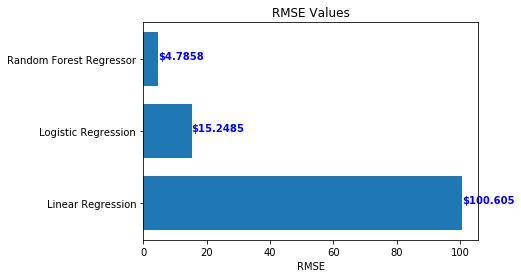

In [53]:
fig, ax = plt.subplots()
y_axis = ('Linear Regression','Logistic Regression','Random Forest Regressor')
y_pos = np.arange(len(y_axis))
width = 0.75 
x_axis = (round(rmse_lr,4),round(rmse_log,4),round(rmse_rfr,4))
ax.barh(y_pos, x_axis, width,align='center')
for i, v in enumerate(x_axis):
    ax.text(v, i, '$'+str(v), color='blue', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_axis)
ax.set_xlabel('RMSE')
ax.set_title('RMSE Values')

# Cross Validation Visualization

Text(0.5, 1.0, 'Cross Validation Values')

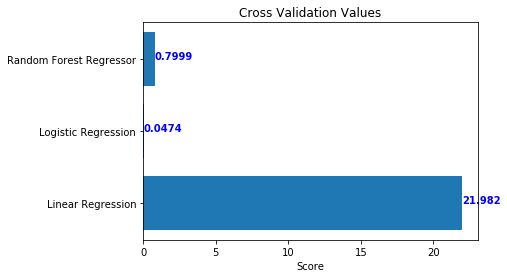

In [54]:
fig, ax = plt.subplots()
y_axis = ('Linear Regression','Logistic Regression','Random Forest Regressor')
y_pos = np.arange(len(y_axis)) 
x_axis = (round(score_lr,4),round(score_log,4),round(score_rfr,4))
ax.barh(y_pos, x_axis, width,align='center')
for i, v in enumerate(x_axis):
    ax.text(v, i, str(v), color='blue', fontweight='bold')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_axis)
ax.set_xlabel('Score')
ax.set_title('Cross Validation Values')